# Adjoint Backpropagation

Possibly the most inefficient backpropagation implementation you'll ever see.

The notebook implements backpropagation through the weights of a Multi Layer Perceptron following the adjoint equations. These equations are a general framework for the computation of a gradient through sequential operations.

To be efficient for large networks, adjoint backpropagation requires implementation care, which we did not do here as the goal is only to provide a minimal example.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Activations

In [2]:
class Sigmoid():
    def __call__(self,z):
        
        return 1/(1+np.exp(-z))
        
    def jac(self,z):
        a = self(z)
        prime = a*(1-a)
        return [np.diag(p) for p in prime]
    
class ReLU():
    
    def __call__(self,z):
        
        return np.maximum(0,z)
    
    def jac(self,z):
        
        temp = np.zeros(z.shape)
        temp[z>0.] = 1
        return [np.diag(t) for t in temp]
        
class Identity():
    
    def __call__(self,z):
        return z
    
    def jac(self,z):
        return [np.eye(len(z_i)) for z_i in z]
    

## The Fully Connected Layer

In [3]:
class Linear():

    def __init__(self,d_in,d_out,act = Sigmoid(),init=1):
        self.d_in, self.d_out = d_in, d_out
        self.w = init * np.random.randn(d_in*d_out).reshape(d_in,d_out)
        self.b = init * np.random.randn(1,d_out)
        self.act = act
        
    def __call__(self,x):
        self.x = x # Remember input for backprop
        z = x.dot(self.w)+self.b
        a = self.act(z)
        return a

    def adjoint_step(self,z,mu):
        
        
        da_dz = self.act.jac(z)
        grad = [np.matmul(da,self.w.T) for da in da_dz]
        vjp_x = np.stack([mu_i.dot(grad_i) for (mu_i,grad_i) in zip(mu,grad)])
        
        
        dz_dw = [self.get_weights_jacobian(x_i) for x_i in self.x]
        grad_w = [da.dot(dz) for (da,dz) in zip(da_dz,dz_dw)]
        dl_dw = np.array([mu_i.dot(grad) for (mu_i,grad) in zip(mu,grad_w)]).mean(0)
        self.dl_dw = -dl_dw.reshape(self.d_out,self.d_in).T
        
        dz_db = np.eye(self.d_out)
        grad_b = [da.dot(dz_db) for da in da_dz]
        dl_db = np.array([mu_i.dot(grad) for (mu_i,grad) in zip(mu,grad_b)]).mean(0)
        self.dl_db = -dl_db.reshape(1,-1)
        
        return vjp_x 
    def get_weights_jacobian(self,x_i):
        # There must be a better way !
        line = np.zeros(self.d_in*self.d_out)
        line[:x_i.shape[0]] = x_i
        return np.stack([np.roll(line,i*self.d_in) for i in range(self.d_out)])
    
    def gradient_step(self,lr,wd=0.):
        
        self.w = self.w - lr * (self.dl_dw + wd * self.w)
        self.b = self.b - lr * (self.dl_db + wd * self.b)

In [4]:
class MLP():
    
    def __init__(self,sizes,act=Sigmoid(),init=1.):
        
        assert len(sizes)>2, "Assumes at least one hidden layer"
        n_layers = len(sizes)-1
        self.layers = [Linear(sizes[i],sizes[i+1],act=act) 
                          for i in range(n_layers-1)]
        self.layers.append(Linear(sizes[-2],sizes[-1],act=Identity(),init=init))
        
    def __call__(self,x):
        
        for l in self.layers:
            x = l(x)
        return x
    
    def backpropagate(self,z,mu):
        
        for l in self.layers[::-1]:
            mu = l.adjoint_step(z,mu)
            z = l.x
    
    def gradient_step(self,lr,wd=0.):
        
        for l in self.layers:
            l.gradient_step(lr,wd)


In [5]:
class MSELoss():
    def __call__(self,x,y):
        loss = 0.5*np.mean(np.sum((x-y)**2,1))
        adjoint_state = -(1/x.shape[0]) * (x-y)
        return loss, adjoint_state
    

## Linear Regression

In [6]:
x = np.random.uniform(0.,1.,size=100).reshape(-1,1)
#y = 10*np.sin(2*np.pi*x) + 3
#y = 10*(-x**2+10*x)
y = 10*x +3
sizes = [1,64,128,64,1]
lossfunc = MSELoss()
network = MLP(sizes,act=Sigmoid())
lr = 1
wd = 1e-4
losses = []
batch_size = 50

In [7]:
pbar = tqdm(range(75))
for i in pbar:
    for j in range(int(x.shape[0]/batch_size)):
        x_j, y_j = x[j*batch_size:(j+1)*batch_size], y[j*batch_size:(j+1)*batch_size]
        out = network(x_j)
        loss, adjoint_state = lossfunc(out,y_j)
        network.backpropagate(out,adjoint_state)
        network.gradient_step(lr,wd)
        losses.append(loss)
    pbar.set_description('Loss : {:.3e}'.format(loss))

Loss : 1.157e-01: 100%|██████████| 75/75 [02:13<00:00,  1.78s/it]


Text(0.5, 0.98, 'Slow to learn')

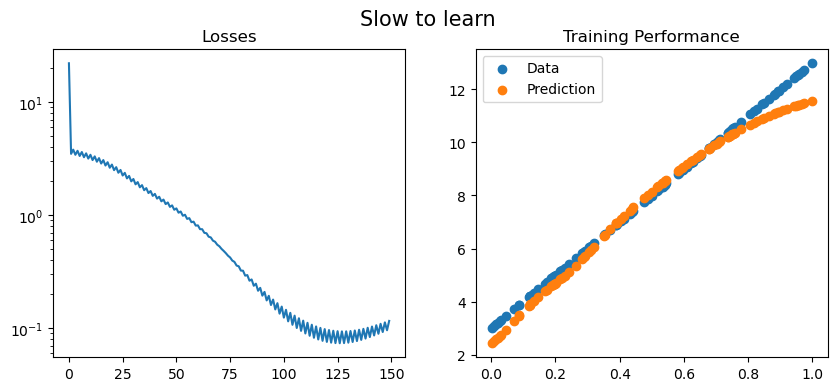

In [9]:
out = network(x)
fig, axs= plt.subplots(ncols=2,figsize=(10,4))
plt.sca(axs[0])
plt.semilogy(losses)
plt.title('Losses')
plt.sca(axs[1])
plt.title('Training Performance')

plt.scatter(x,y,label='Data')
plt.scatter(x,out,label='Prediction')
plt.legend()
fig.suptitle('Slow to learn',fontsize=15)

## ReLU

In [10]:
x = np.random.uniform(0.,1.,size=100).reshape(-1,1)
#y = 10*np.sin(2*np.pi*x) + 3
#y = 10*(-x**2+10*x)
y = 10*x +3
sizes = [1,64,128,64,1]
lossfunc = MSELoss()
network = MLP(sizes,act=ReLU(),init=1e-4)
lr = 1e-3
wd = 1e-4
losses = []
batch_size = 50

In [11]:
pbar = tqdm(range(75))
for i in pbar:
    for j in range(int(x.shape[0]/batch_size)):
        x_j, y_j = x[j*batch_size:(j+1)*batch_size], y[j*batch_size:(j+1)*batch_size]
        out = network(x_j)
        loss, adjoint_state = lossfunc(out,y_j)
        network.backpropagate(out,adjoint_state)
        network.gradient_step(lr,wd)
        losses.append(loss)
    pbar.set_description('Loss : {:.3e}'.format(loss))

Loss : 5.876e-03: 100%|██████████| 75/75 [02:22<00:00,  1.90s/it]


Text(0.5, 0.98, 'Almost as good as linear regression :D')

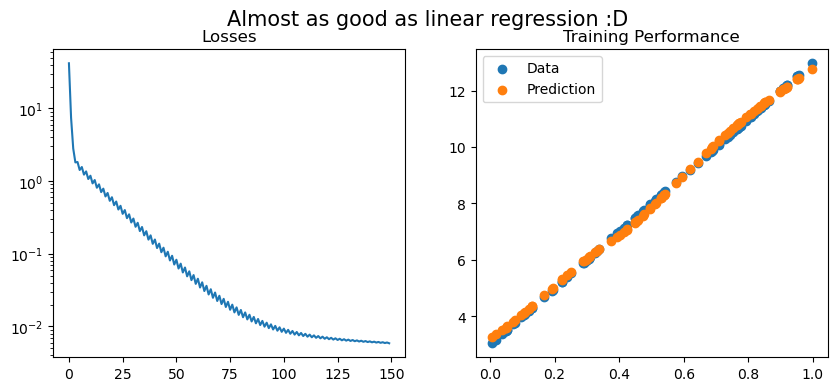

In [13]:
out = network(x)
fig, axs= plt.subplots(ncols=2,figsize=(10,4))
plt.sca(axs[0])
plt.semilogy(losses)
plt.title('Losses')
plt.sca(axs[1])
plt.title('Training Performance')

plt.scatter(x,y,label='Data')
plt.scatter(x,out,label='Prediction')
plt.legend()
fig.suptitle('Almost as good as linear regression :D',fontsize=15)

## Creating Readme

In [14]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [15]:
os.system('rm backpropagation_numpy_files/*')
os.system('jupyter nbconvert --to markdown backpropagation_numpy.ipynb')
os.system('mv backpropagation_numpy.md README.md')
os.system('git add backpropagation_numpy_files/')


rm: impossible de supprimer 'backpropagation_numpy_files/*': Aucun fichier ou dossier de ce type
[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook backpropagation_numpy.ipynb to markdown
[NbConvertApp] Support files will be in backpropagation_numpy_files/
[NbConvertApp] Making directory backpropagation_numpy_files
[NbConvertApp] Making directory backpropagation_numpy_files
[NbConvertApp] Writing 6617 bytes to backpropagation_numpy.md
mv: impossible d'évaluer 'manifold_identification.md': Aucun fichier ou dossier de ce type


0